<a href="https://colab.research.google.com/github/workingbetter/Optimisation_Project_2/blob/main/Optimisation_3071806.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Maximising a Function

In [ ]:
import random
import math

def f(x, y, z):
    return (
        math.exp(math.cos(53 * z))
        + math.sin(43 * math.exp(y))
        + math.exp(math.sin(29 * x))
        + math.sin(67 * math.sin(z))
        + math.cos(math.cos(37 * y))
        - (2 * x ** 2 + y ** 2 + z ** 2) / 4
    )

def random_search(steps):
    xb = random.uniform(-1, 1)
    yb = random.uniform(-1, 1)
    zb = random.uniform(-1, 1)
    fbest = f(xb, yb, zb)

    for _ in range(steps):
        xn = random.uniform(-1, 1)
        yn = random.uniform(-1, 1)
        zn = random.uniform(-1, 1)
        fnew = f(xn, yn, zn)

        if fnew > fbest:
            xb = xn
            yb = yn
            zb = zn
            fbest = fnew

    return (xb, yb, zb), fbest

def hill_climbing(steps, sigma=0.1):
    xb = random.uniform(-1, 1)
    yb = random.uniform(-1, 1)
    zb = random.uniform(-1, 1)
    fbest = f(xb, yb, zb)

    for _ in range(steps):
        xn = xb + random.gauss(0, sigma)
        yn = yb + random.gauss(0, sigma)
        zn = zb + random.gauss(0, sigma)
        fnew = f(xn, yn, zn)

        if fnew > fbest:
            xb = xn
            yb = yn
            zb = zn
            fbest = fnew

    return (xb, yb, zb), fbest

# Set the number of runs and steps
num_runs = 50
num_steps = 10000

# Run both algorithms multiple times and collect results
random_search_results = []
hill_climbing_results = []

for _ in range(num_runs):
    random_search_results.append(random_search(num_steps))
    hill_climbing_results.append(hill_climbing(num_steps))

# Find and print the maximum values for both algorithms
random_search_max = max(random_search_results, key=lambda x: x[1])
hill_climbing_max = max(hill_climbing_results, key=lambda x: x[1])

print(f"Number of runs: {num_runs}")
print(f"Number of steps: {num_steps}")

print("Random search:")
print("Maximum value:", random_search_max[1])
print("Best solution: x =", random_search_max[0][0], ", y =", random_search_max[0][1], ", z =", random_search_max[0][2])

print("\nHill climbing:")
print("Maximum value:", hill_climbing_max[1])
print("Best solution: x =", hill_climbing_max[0][0], ", y =", hill_climbing_max[0][1], ", z =", hill_climbing_max[0][2])


Number of runs: 50
Number of steps: 10000
Random search:
Maximum value: 8.351122094311705
Best solution: x = 0.05066574577501859 , y = 0.2977675151748942 , z = 0.11625179596100743

Hill climbing:
Maximum value: 8.326618882846196
Best solution: x = 0.049803241974865624 , y = 0.29915417887546 , z = -0.3577974169445486


# Part 2: Distribution Network

In [ ]:
import sys
import math
import random
import heapq
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.cluster import KMeans
import numpy as np


class Graph:

    def __init__(self, vertices):
        self.vertices = vertices
        self.n = len(vertices)

    def x(self, v):
        return self.vertices[v][0]

    def y(self, v):
        return self.vertices[v][1]

    _d_lookup = {}

    def d(self, u, v):
        if (u, v) in self._d_lookup:
            return self._d_lookup[(u, v)]
        _distance = math.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)
        self._d_lookup[(u, v)], self._d_lookup[(v, u)] = _distance, _distance
        return _distance

class Route:

    def __init__(self, g, vertices=None):
        self.g = g
        if vertices is None:
            self.vertices = list(range(1, g.n))
            random.shuffle(self.vertices)
        else:
            self.vertices = vertices
        self.__cost = None

    def cost(self):
        if self.__cost is None:
            self.__cost = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
                self.__cost += self.g.d(self.g.vertices[i], self.g.vertices[j])
        return self.__cost

class GeneticAlgorithm:

    def __init__(self, g, population_size, k=5, elite_mating_rate=0.5,
                 mutation_rate=0.015, mutation_swap_rate=0.2):
        self.g = g
        self.population = []
        for _ in range(population_size):
            self.population.append(Route(g))
        self.population_size = population_size
        self.k = k
        self.elite_mating_rate = elite_mating_rate
        self.mutation_rate = mutation_rate
        self.mutation_swap_rate = mutation_swap_rate

    def crossover(self, mum, dad):
        size = len(mum.vertices)
        alice, bob = [-1] * size, [-1] * size
        start, end = sorted([random.randrange(size) for _ in range(2)])

        for i in range(start, end + 1):
            alice[i] = mum.vertices[i]
            bob[i] = dad.vertices[i]

        current_dad_position, current_mum_position = 0, 0
        for i in chain(range(start), range(end + 1, size)):
            while dad.vertices[current_dad_position] in alice:
                current_dad_position += 1
            while mum.vertices[current_mum_position] in bob:
                current_mum_position += 1

            alice[i] = dad.vertices[current_dad_position]
            bob[i] = mum.vertices[current_mum_position]

        return Route(self.g, alice), Route(self.g, bob)

    def mutate(self, route):
        if random.random() < self.mutation_rate:
            for i in range(len(route.vertices)):
                if random.random() < self.mutation_swap_rate:
                    j = random.randrange(len(route.vertices))
                    route.vertices[i], route.vertices[j] = route.vertices[j], route.vertices[i]


    def select_parent(self, k):
        tournament = random.sample(self.population, k)
        return min(tournament, key=lambda route: route.cost())

    def evolve(self):
        new_population = []

        elites = int(self.elite_mating_rate * self.population_size)
        new_population.extend(heapq.nsmallest(elites, self.population, key=lambda route: route.cost()))

        while len(new_population) < self.population_size:
            mum = self.select_parent(self.k)
            dad = self.select_parent(self.k)

            alice, bob = self.crossover(mum, dad)
            self.mutate(alice)
            self.mutate(bob)

            new_population.append(alice)
            new_population.append(bob)

        self.population = new_population

def find_optimal_routes(vertices, n_clusters, n_genetic_iterations, population_size=100):
    g = Graph(vertices)

    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(vertices)

    subgraphs = [[] for _ in range(n_clusters)]
    for i, cluster_label in enumerate(cluster_labels):
        subgraphs[cluster_label].append(vertices[i])

    optimal_routes = []
    for subgraph in subgraphs:
        ga = GeneticAlgorithm(Graph(subgraph), population_size)
        for _ in range(n_genetic_iterations):
            ga.evolve()
        optimal_routes.append(min(ga.population, key=lambda route: route.cost()))

    return optimal_routes


def assign_warehouses(optimal_routes, warehouse_positions):
    g = Graph(warehouse_positions)
    warehouse_routes = {i: [] for i in range(len(warehouse_positions))}
    for cluster_idx, route in enumerate(optimal_routes):
        min_distance = float('inf')
        min_warehouse_idx = None
        for warehouse_idx, warehouse in enumerate(warehouse_positions):
            for store in route.vertices:
                distance = g.d(warehouse, route.g.vertices[store])
                if distance < min_distance:
                    min_distance = distance
                    min_warehouse_idx = warehouse_idx
        warehouse_routes[min_warehouse_idx].append(route)
    return warehouse_routes




def main():
    vertices = [
        (54.13917237, 10.16301447),
        (5.163117855, 18.37136899),
        (58.10773412, 97.325872),
        (16.60663876, 73.67529068),
        (10.92151473, 26.90262604),
        (40.2830426, 49.00596112),
        (95.90679501, 31.25379214),
        (38.80688537, 61.84963412),
        (50.77362816, 41.71229884),
        (16.12104517, 4.174152112),
        (30.57252604, 25.66416139),
        (88.65418483, 28.60340585),
        (76.15833298, 52.06010201),
        (57.99079029, 58.29016932),
        (80.11801005, 80.74242101),
        (90.87902761, 90.97690565),
        (2.587207522, 45.80849397),
        (74.04980053, 2.986131158),
        (71.70911665, 37.25817058),
        (22.37191714, 94.53074723),
        (24.10112206, 11.06658123),
        (42.27800052, 9.141860385),
        (58.3280586, 76.15907608),
    ]


    warehouse_positions = [
        (0, 0),
        (100, 100),
    ]

    vehicle_specs = [
        {'type': 'Van', 'cost_per_mile': 1, 'max_stores': 4},
        {'type': 'Lorry', 'cost_per_mile': 2, 'max_stores': 16},
    ]


    n_clusters = 2
    n_genetic_iterations = 1000
    optimal_routes = find_optimal_routes(vertices, n_clusters, n_genetic_iterations, population_size=100)
    warehouse_routes = assign_warehouses(optimal_routes, warehouse_positions)

    total_cost = 0

    for warehouse_idx, routes in warehouse_routes.items():
        print(f"Warehouse {warehouse_idx + 1}:")
        
        vehicle_counts = [0, 0]
        for route in routes:
            route_cost_van = route.cost() * vehicle_specs[0]['cost_per_mile']
            route_cost_lorry = route.cost() * vehicle_specs[1]['cost_per_mile']
            
            if len(route.vertices) <= vehicle_specs[0]['max_stores'] and route_cost_van <= route_cost_lorry:
                vehicle_counts[0] += 1
                route.vehicle_type = vehicle_specs[0]
            else:
                vehicle_counts[1] += 1
                route.vehicle_type = vehicle_specs[1]
        
        for vehicle_idx, vehicle_spec in enumerate(vehicle_specs):
            num_vehicles = vehicle_counts[vehicle_idx]
            print(f"{num_vehicles} {vehicle_spec['type']}s")

        for route in routes:
            cost = route.cost() * route.vehicle_type['cost_per_mile']
            print(f"Route: Stores: {route.vertices}, Total cost: £{cost:.2f}")
            total_cost += cost

    print(f"Total cost: £{total_cost:.2f}")

if __name__ == "__main__":
    main()


Warehouse 1:
0 Vans
1 Lorrys
Route: Stores: [6, 8, 7, 3, 1, 2, 5, 4], Total cost: £387.86
Warehouse 2:
0 Vans
1 Lorrys
Route: Stores: [10, 9, 13, 8, 6, 3, 7, 11, 5, 2, 4, 1, 12], Total cost: £625.32
Total cost: £1013.17


Generation 0: Cost 1865.3035698709496
Generation 50: Cost 1142.5853417402714
Generation 100: Cost 1142.5853417402714
Generation 150: Cost 1142.5853417402714
Generation 200: Cost 1142.5853417402714
Generation 250: Cost 1142.5853417402714
Generation 300: Cost 1142.5853417402714
Generation 350: Cost 1142.5853417402714
Generation 400: Cost 1142.5853417402714
Generation 450: Cost 1142.5853417402714
Best Delivery Strategy:
W1: 1, 22, 5, 2, 10, 21, 11, 9, 19, 13, 7, 12, 18
W2: 4, 17, 6, 8, 14, 15, 16, 3, 20, 23

Vehicle Requirements:
W1: 4 vans, 0 lorries
W2: 3 vans, 0 lorries

Routes:
W1 -> van -> 1, 22, 5, 2 -> W1
W1 -> van -> 10, 21, 11, 9 -> W1
W1 -> van -> 19, 13, 7, 12 -> W1
W1 -> van -> 18 -> W1
W2 -> van -> 4, 17, 6, 8 -> W2
W2 -> van -> 14, 15, 16, 3 -> W2
W2 -> van -> 20, 23 -> W2

Total Cost: £1142.5853417402714

Plotting Routes:


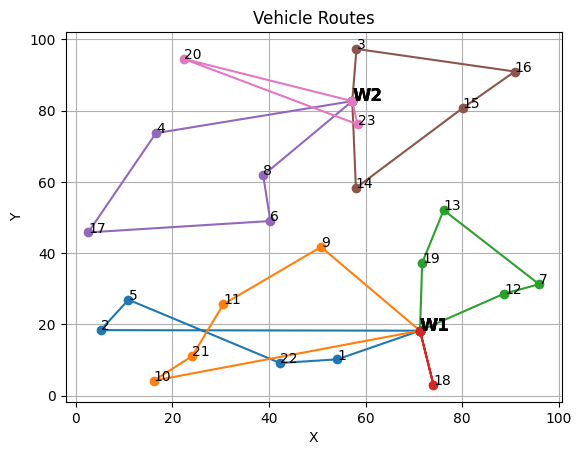

In [41]:
import sys
import math
import random
import heapq
import matplotlib.pyplot as plt
from itertools import chain

# Constants
WAREHOUSES = ['W1', 'W2']
STORES = [i for i in range(1, 24)]
POPULATION_SIZE = 100
GENERATIONS = 500
MUTATION_RATE = 0.1
VAN_CAPACITY = 4
LORRY_CAPACITY = 16
VAN_COST = 1
LORRY_COST = 2

# Location data
LOCATIONS = {
    1: (54.13917237, 10.16301447),
    2: (5.163117855, 18.37136899),
    3: (58.10773412, 97.325872),
    4: (16.60663876, 73.67529068),
    5: (10.92151473, 26.90262604),
    6: (40.2830426, 49.00596112),
    7: (95.90679501, 31.25379214),
    8: (38.80688537, 61.84963412),
    9: (50.77362816, 41.71229884),
    10: (16.12104517, 4.174152112),
    11: (30.57252604, 25.66416139),
    12: (88.65418483, 28.60340585),
    13: (76.15833298, 52.06010201),
    14: (57.99079029, 58.29016932),
    15: (80.11801005, 80.74242101),
    16: (90.87902761, 90.97690565),
    17: (2.587207522, 45.80849397),
    18: (74.04980053, 2.986131158),
    19: (71.70911665, 37.25817058),
    20: (22.37191714, 94.53074723),
    21: (24.10112206, 11.06658123),
    22: (42.27800052, 9.141860385),
    23: (58.3280586, 76.15907608),
    'W1': (71.25359844, 18.21268482),
    'W2': (57.24219473, 82.66876117),
}



def distance(a, b):
    return math.sqrt((LOCATIONS[a][0] - LOCATIONS[b][0]) ** 2 + (LOCATIONS[a][1] - LOCATIONS[b][1]) ** 2)


def create_individual():
    individual = {warehouse: [] for warehouse in WAREHOUSES}
    
    for store in STORES:
        closest_warehouse = min(WAREHOUSES, key=lambda w: distance(w, store))
        individual[closest_warehouse].append(store)
    
    return individual

def ordered_crossover(parent1, parent2, warehouse):
    # Find crossover points
    start, end = sorted(random.sample(range(len(parent1[warehouse])), 2))
    
    # Initialize child
    child = [None] * len(parent1[warehouse])
    
    # Copy the stores between the crossover points from parent1
    child[start:end+1] = parent1[warehouse][start:end+1]
    
    # Fill the rest of the child with stores from parent2
    p2_stores = (store for store in parent2[warehouse] if store not in child)
    for i in chain(range(start), range(end+1, len(child))):
        child[i] = next(p2_stores)
    
    return child

def calculate_cost(individual):
    total_cost = 0
    for warehouse, stores in individual.items():
        if not stores:
            continue
        vehicle_count = math.ceil(len(stores) / VAN_CAPACITY)
        vehicle_cost = VAN_COST
        if len(stores) > VAN_CAPACITY:
            vehicle_count = math.ceil(len(stores) / LORRY_CAPACITY)
            vehicle_cost = LORRY_COST

        cost = distance(warehouse, stores[0]) * vehicle_cost
        for i in range(len(stores) - 1):
            cost += distance(stores[i], stores[i + 1]) * vehicle_cost
        cost += distance(stores[-1], warehouse) * vehicle_cost
        cost *= vehicle_count
        total_cost += cost

    return total_cost


def crossover(parent1, parent2):
    child = {}
    
    for warehouse in WAREHOUSES:
        if random.random() < 0.5:
            child[warehouse] = ordered_crossover(parent1, parent2, warehouse)
        else:
            child[warehouse] = ordered_crossover(parent2, parent1, warehouse)

    return child



def mutate(individual):
    for warehouse, stores in individual.items():
        if random.random() < MUTATION_RATE:
            a, b = random.sample(range(len(stores)), 2)
            stores[a], stores[b] = stores[b], stores[a]

    return individual



def genetic_algorithm():
    # Initialize the population based on the improved create_individual function
    population = [create_individual() for _ in range(POPULATION_SIZE)]

    for generation in range(GENERATIONS):
        population.sort(key=calculate_cost)

        if generation % 50 == 0:
            print(f"Generation {generation}: Cost {calculate_cost(population[0])}")

        new_population = population[:2]  # Elitism

        while len(new_population) < POPULATION_SIZE:
            parent1, parent2 = random.sample(population[:10], 2)
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)

        population = new_population

    return population[0]
    

def route_summary(individual):
    summary = {}
    for warehouse, stores in individual.items():
        routes = []

        for i in range(0, len(stores), VAN_CAPACITY):
            route_stores = stores[i: i + VAN_CAPACITY]

            van_cost = VAN_COST * (distance(warehouse, route_stores[0]) + distance(route_stores[-1], warehouse))
            for j in range(len(route_stores) - 1):
                van_cost += VAN_COST * distance(route_stores[j], route_stores[j + 1])

            lorry_cost = LORRY_COST * (distance(warehouse, route_stores[0]) + distance(route_stores[-1], warehouse))
            for j in range(len(route_stores) - 1):
                lorry_cost += LORRY_COST * distance(route_stores[j], route_stores[j + 1])

            if van_cost <= lorry_cost:
                routes.append((warehouse, 'van', route_stores))
            else:
                routes.append((warehouse, 'lorry', route_stores))

        summary[warehouse] = {
            'routes': routes,
        }

    return summary







def plot_routes(summary):
    for warehouse, details in summary.items():
        for _, vehicle_type, route_stores in details['routes']:
            x = [LOCATIONS[warehouse][0]] + [LOCATIONS[store][0] for store in route_stores] + [LOCATIONS[warehouse][0]]
            y = [LOCATIONS[warehouse][1]] + [LOCATIONS[store][1] for store in route_stores] + [LOCATIONS[warehouse][1]]
            
            plt.plot(x, y, marker='o')
            plt.text(LOCATIONS[warehouse][0], LOCATIONS[warehouse][1], warehouse, fontsize=12, fontweight='bold')
            for store in route_stores:
                plt.text(LOCATIONS[store][0], LOCATIONS[store][1], str(store), fontsize=10)
            
    plt.title("Vehicle Routes")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.show()

def main():
    best_individual = genetic_algorithm()
    total_cost = calculate_cost(best_individual)
    summary = route_summary(best_individual)



    print("Best Delivery Strategy:")
    for warehouse, stores in best_individual.items():
        print(f"{warehouse}: {', '.join(map(str, stores))}")

    print("\nVehicle Requirements:")
    for warehouse, details in summary.items():
        van_count = sum(1 for _, vehicle_type, _ in details['routes'] if vehicle_type == 'van')
        lorry_count = sum(1 for _, vehicle_type, _ in details['routes'] if vehicle_type == 'lorry')
        print(f"{warehouse}: {van_count} vans, {lorry_count} lorries")

    print("\nRoutes:")
    for warehouse, details in summary.items():
        for _, vehicle_type, route_stores in details['routes']:
            print(f"{warehouse} -> {vehicle_type} -> {', '.join(map(str, route_stores))} -> {warehouse}")

    print(f"\nTotal Cost: £{total_cost}")


    print("\nPlotting Routes:")
    plot_routes(summary)

if __name__ == "__main__":
    main()

